In [143]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [144]:
data=pd.read_excel('../product_performance_blstm\dataset_new.xlsx',sheet_name='train')
data

,KodeBarang,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,cluster
0,04121,7,9,6,9,40,0,3,0,7,...,67,77,11,57,43,50,37,21,136,0
1,18031,230,227,279,153,190,256,267,305,238,...,336,153,103,221,360,280,240,120,548,1
2,04161,102,50,45,41,71,11,52,14,66,...,21,20,7,33,21,28,30,10,18,0
3,04162,272,155,214,226,268,110,204,253,193,...,102,118,120,211,292,105,108,101,117,1
4,04163,28,28,29,52,44,21,47,15,24,...,18,23,22,16,22,31,36,17,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,04157,55,64,44,61,30,1,24,37,67,...,20,10,300,34,7,7,6,4,21,0
102,18104,46,295,83,112,70,40,18,140,97,...,47,54,27,15,57,132,66,34,146,0
103,18106,200,204,0,2,10,7,0,27,74,...,15,136,15,15,14,131,84,12,14,0
104,18092,297,418,329,70,498,59,298,376,259,...,450,498,254,260,336,493,438,408,322,1


In [191]:
data_test = pd.read_excel('../product_performance_blstm\dataset_new.xlsx',sheet_name='test')
data_test

,KodeBarang,bulan 1,bulan 2,bulan 3,bulan 4,bulan 5,bulan 6
0,04121,5,12,8,14,40,40
1,18031,573,340,441,270,488,240
2,04161,27,5,26,34,40,56
3,04162,162,82,72,98,126,120
4,04163,23,20,9,5,22,6
...,...,...,...,...,...,...,...
101,04157,138,14,12,21,25,10
102,18104,60,103,39,87,276,40
103,18106,16,7,65,24,13,27
104,18092,721,184,150,488,648,149


In [193]:
data_test['cluster'] = data['cluster'].astype(int)
data_test.drop(['bulan 4','bulan 5','bulan 6'],axis=1,inplace=True)

In [194]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [195]:
len(data['cluster'].unique())

4

In [196]:
#now lets take clusters
c0 = data.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1 = data.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2 = data.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3 = data.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


In [197]:
c0_t = data_test.query("cluster == 0")
print("Jumlah Produk:")
print(c0['KodeBarang'].size)
c1_t = data_test.query("cluster == 1")
print("Jumlah Produk:")
print(c1['KodeBarang'].size)
c2_t = data_test.query("cluster == 2")
print("Jumlah Produk:")
print(c2['KodeBarang'].size)
c3_t = data_test.query("cluster == 3")
print("Jumlah Produk:")
print(c3['KodeBarang'].size)

Jumlah Produk:
70
Jumlah Produk:
31
Jumlah Produk:
4
Jumlah Produk:
1


In [198]:
#oke ada ternyata yang cuman sendirian (1 product di cluster tersebut), kita beresin dia dulu, the easiest, dan biar keliatan kita
#ngapain aja di time series ini
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
# ini fungsinya buat nge ubah dataset jadi windowed

In [199]:
col = c2.KodeBarang.values
col

array(['18004', '18063', '04105', '18111'], dtype=object)

In [200]:
#next kita ubah bentuk data nya dari yang tadinya kesamping jadi ke bawah, tapi pertama mau aku drop dulu cluster sama kode produknya
c2=c2.drop(columns=['KodeBarang','cluster'])
c2_t = c2_t.drop(columns=['KodeBarang','cluster'])

<AxesSubplot:>

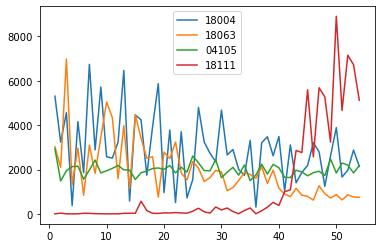

In [201]:
c2.set_index(col,inplace=True)
c2.T.plot()

## Skip

In [203]:
#next, buat dia kayak mejeneng time series seperti biasanya, which is datanya ke bawah, tapi di average per tanggal 
new_c2=[]
time=[]
for idx,a in enumerate(c2):
    new_c2.append(c2[a].mean())
    time.append(idx)


In [202]:
new_c2_t=[]
time_t=[]
i = 55
for idx,a in enumerate(c2_t):
    new_c2_t.append(c2_t[a].mean())
    time_t.append(i)
    i+=1

In [204]:
#normalisasi, karena gap nya ada yang sampe ribuan, biar lebih gampang tugas ann nya
series=new_c2
min = np.min(series)
max = np.max(series)
series = series - min
series = series / (max-min)
time = np.array(time)

In [219]:
series

array([0.64191071, 0.26837708, 0.82969027, 0.01333446, 0.47404844,
       0.05240949, 0.68959406, 0.29394886, 0.6222466 , 0.49734155,
       0.44290657, 0.2823023 , 0.74149717, 0.00548569, 0.57760149,
       0.54122711, 0.22575745, 0.41353701, 0.42678707, 0.1798464 ,
       0.40762934, 0.16819985, 0.33943793, 0.04253524, 0.25149802,
       0.48510423, 0.26002194, 0.2266014 , 0.28728163, 0.39868343,
       0.18415056, 0.22145329, 0.13528568, 0.19334965, 0.26955861,
       0.        , 0.34213858, 0.2769854 , 0.31082792, 0.29057304,
       0.07637775, 0.248291  , 0.31361296, 0.31276901, 0.5593721 ,
       0.38813402, 0.67566883, 0.46375222, 0.45387796, 1.        ,
       0.471179  , 0.71887923, 0.72141109, 0.55084817])

In [205]:
series_t=new_c2_t
min = np.min(series_t)
max = np.max(series_t)
series_t = series_t - min
series_t = series_t / (max-min)
time_t = np.array(time_t)

In [206]:
series_t

array([0.50395634, 1.        , 0.        ])

In [207]:
split_time = 3 # ini berapa bulan terkahir yang mau di potong buat pengujian?

time_train = time
x_train =  series
time_valid =  time_t
x_valid =  series_t

In [208]:
# #buat data biar dibagi per window, jadi me masang masangkan waktu dan value,
window_size = 2
batch_size = 2
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [160]:
# train_set

In [161]:
# valid_set

In [162]:
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [209]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
        tf.keras.layers.Dropout(0.5),
        
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(1024, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        
        # tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l1=0.01)),
        # tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
        # tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation='relu')
    ])

    

    #the blstm part

In [210]:
#Using mae and mse
#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['mae'],loss='mse')
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4,momentum=0.9),metrics=['mae'],loss='mse')
model.summary()
hist=model.fit(train_set,epochs=400,validation_data=valid_set, batch_size=1)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, None, 20)          40        
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 128)         43520     
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, None, 64)          41216     
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
dense_60 (Dense)             (None, None, 1)           65        
Total params: 84,841
Trainable params: 84,841
Non-trainable params: 0
_________________________________________________

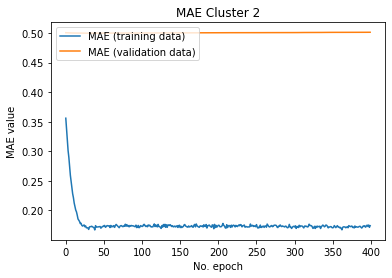

In [211]:
import matplotlib.pyplot as plt
plt.plot(hist.history['mae'], label='MAE (training data)')
plt.plot(hist.history['val_mae'], label='MAE (validation data)')

plt.title("MAE Cluster 2")
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

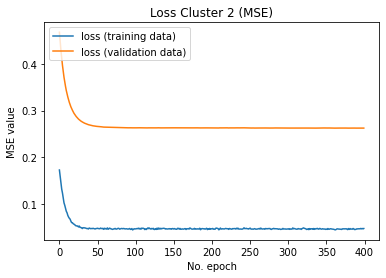

In [212]:
plt.plot(hist.history['loss'], label='loss (training data)')
plt.plot(hist.history['val_loss'], label='loss (validation data)')

plt.title("Loss Cluster 2 (MSE)")
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [213]:
prediksi=model.predict(np.array(x_valid).reshape(-1,1,1))
prediksi

array([[[0.34391904]],

       [[0.36040992]],

       [[0.32719603]]], dtype=float32)

In [214]:
prediksi=prediksi.flatten()

In [215]:
hasil=np.concatenate((series,prediksi))

In [216]:
hasil.shape

(57,)

In [217]:
asli = np.concatenate((series,series_t))

[]

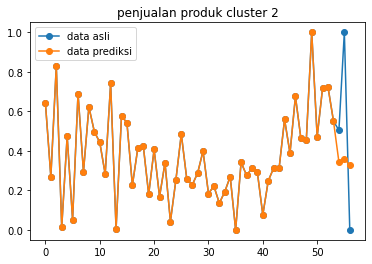

In [218]:
plt.plot(asli,marker = 'o',label='data asli')
plt.plot(hasil,marker = 'o',label='data prediksi')
plt.title('penjualan produk cluster 2')
plt.legend()
plt.plot()

In [172]:
# model.save('cluster2_newdata.h5')